## Configuration

In [1]:
import pandas as pd
from prophet import Prophet
from datetime import timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [2]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mse, predict_mae, init_prophet_model, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

from src.scraping import update_e_mix_data, update_e_price_data, fetch_historical_weather
from src.benchmark import extend_by_predictions_and_samples

In [3]:
update_e_price_data()
update_e_mix_data()
fetch_historical_weather()


Starting update_smard_data function...
Loading existing data...
Loaded 55578 existing records.
Fetching data for the past 1 weeks...
Fetching data for week 1 (starting 2025-02-03)...
Successfully fetched data.
Skipping invalid data point: ts=1738623600000, price=None
Skipping invalid data point: ts=1738627200000, price=None
Skipping invalid data point: ts=1738630800000, price=None
Skipping invalid data point: ts=1738634400000, price=None
Skipping invalid data point: ts=1738638000000, price=None
Skipping invalid data point: ts=1738641600000, price=None
Skipping invalid data point: ts=1738645200000, price=None
Skipping invalid data point: ts=1738648800000, price=None
Skipping invalid data point: ts=1738652400000, price=None
Skipping invalid data point: ts=1738656000000, price=None
Skipping invalid data point: ts=1738659600000, price=None
Skipping invalid data point: ts=1738663200000, price=None
Skipping invalid data point: ts=1738666800000, price=None
Skipping invalid data point: ts=1738

In [4]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2025, 2, 3), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [5]:
merged_df, e_price_df = get_datasets()

## Feature Selection

### Best Feature Set (Prophet)
- TBA
### Best Feature Set (XGBoost)
- TBA

In [6]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [7]:
# RERUN WHEN TICKING the NORMALIZED BOX OR SELECTING SPECIFIC FEATURES

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df.copy())
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df.copy(),eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



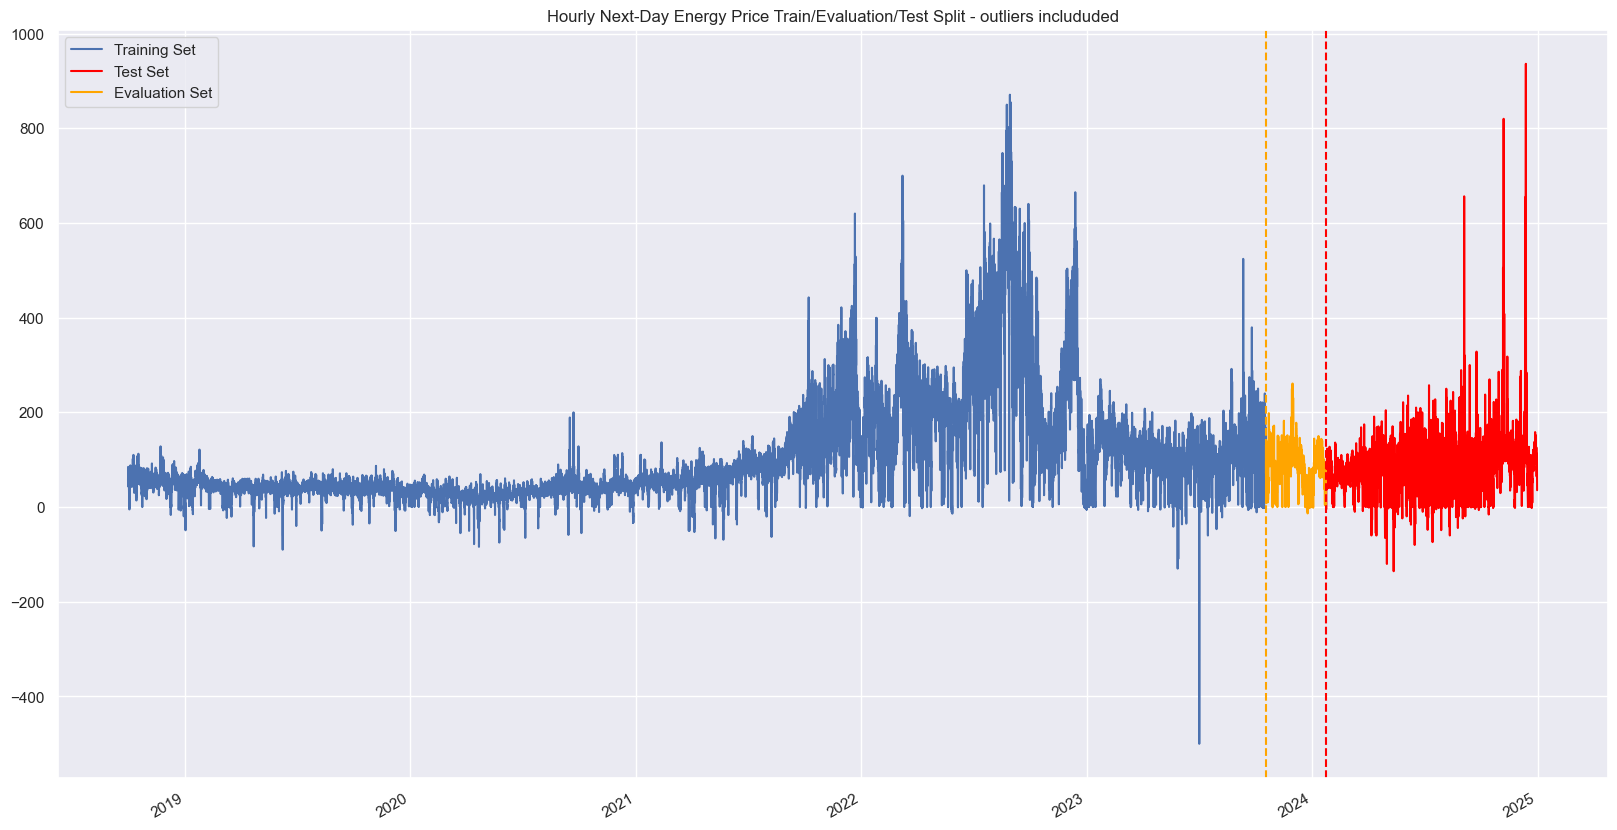

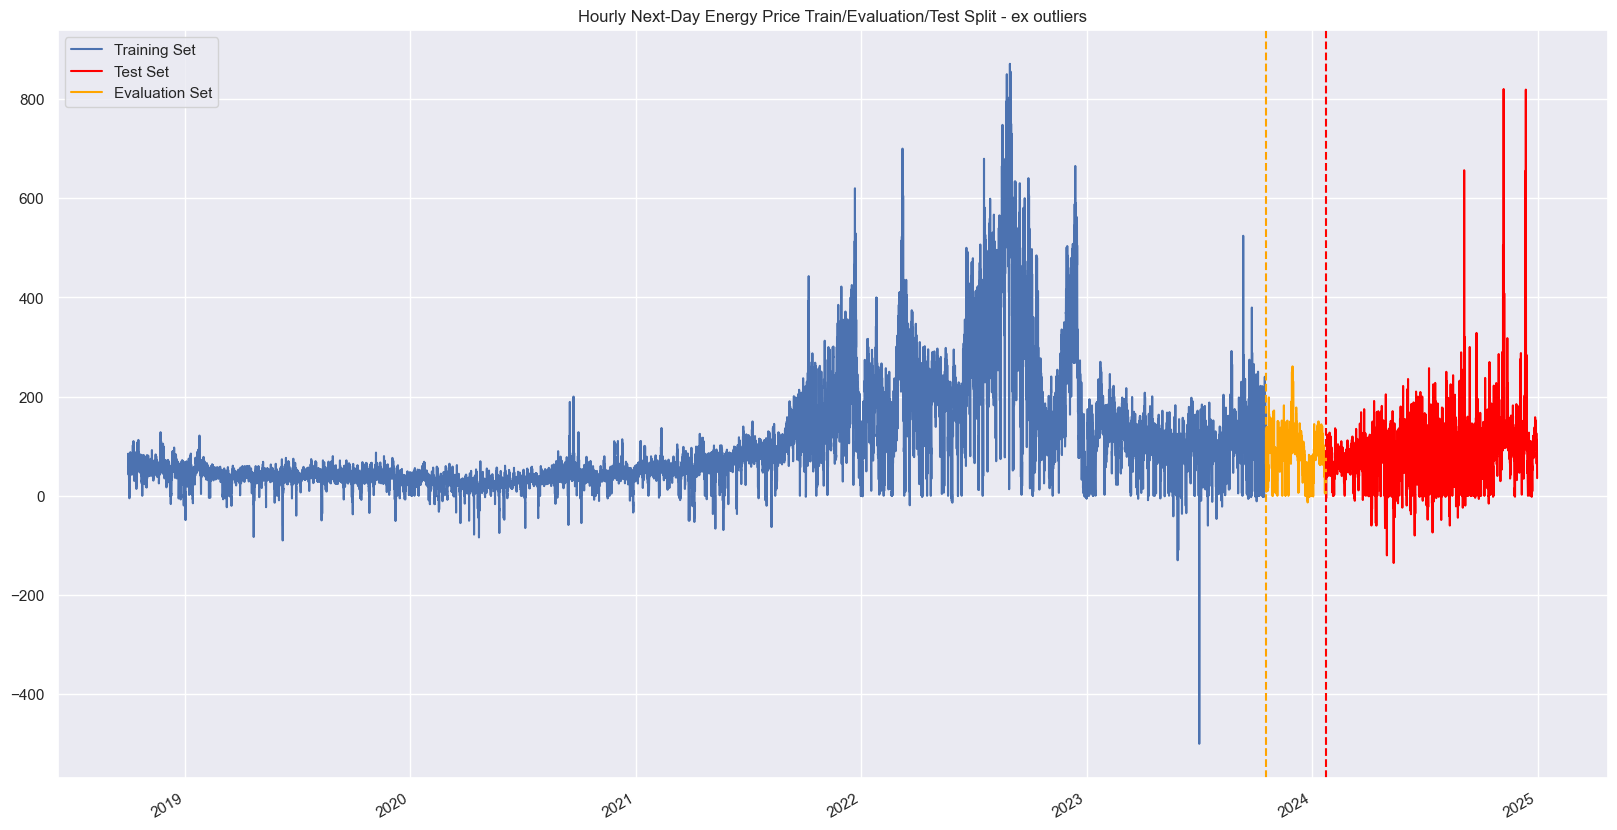

In [8]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [9]:
# RERUN WHEN TICKING the NORMALIZED BOX OR SELECTING SPECIFIC FEATURES
lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [10]:
#RERUN WHEN TICKING the NORMALIZED BOX OR SELECTING SPECIFIC FEATURES
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)


[0]	validation_0-rmse:86.40833
[25]	validation_0-rmse:18.96835
[50]	validation_0-rmse:5.64190
[75]	validation_0-rmse:3.72213
[100]	validation_0-rmse:3.59774
[125]	validation_0-rmse:3.59000
[149]	validation_0-rmse:3.58141
[0]	validation_0-mae:76.59275
[25]	validation_0-mae:16.63813
[50]	validation_0-mae:4.47597
[75]	validation_0-mae:2.55792
[100]	validation_0-mae:2.44166
[125]	validation_0-mae:2.45270
[149]	validation_0-mae:2.45850


### Prophet

In [11]:
#RERUN WHEN TICKING the NORMALIZED BOX OR SELECTING SPECIFIC FEATURES 
# Initialize Prophet model
model = Prophet(
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 1.0,
    holidays_prior_scale = 1.0,
    seasonality_mode= 'multiplicative'
)

#Add fourier order for weekly and monthly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=20)
model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
model.add_seasonality(name='yearly', period=365, fourier_order=20)

# Add time-based regressors

for feature in FEATURES:
     model.add_regressor(feature)
     
train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

model.fit(train_data)

test_data_prophet = test.copy().reset_index().rename(columns={"index": "ds"}).dropna()
test_data_prophet.drop(columns=["Price"])
prophet_predictions = model.predict(test_data_prophet)["yhat"]


10:32:01 - cmdstanpy - INFO - Chain [1] start processing
10:32:42 - cmdstanpy - INFO - Chain [1] done processing


## Results

### Errors

In [12]:
# RERUN WHEN TICKING the NORMALIZED BOX OR SELECTING SPECIFIC FEATURES
calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

            Model       MAE        MSE      RMSE         MAPE
Linear Regression  3.619194  47.113953  6.863960 8.186793e+15
          Prophet  3.644032  46.267443  6.802018 8.557734e+15
          XGBoost 13.276169 589.672540 24.283174 1.246180e+16


### Plots

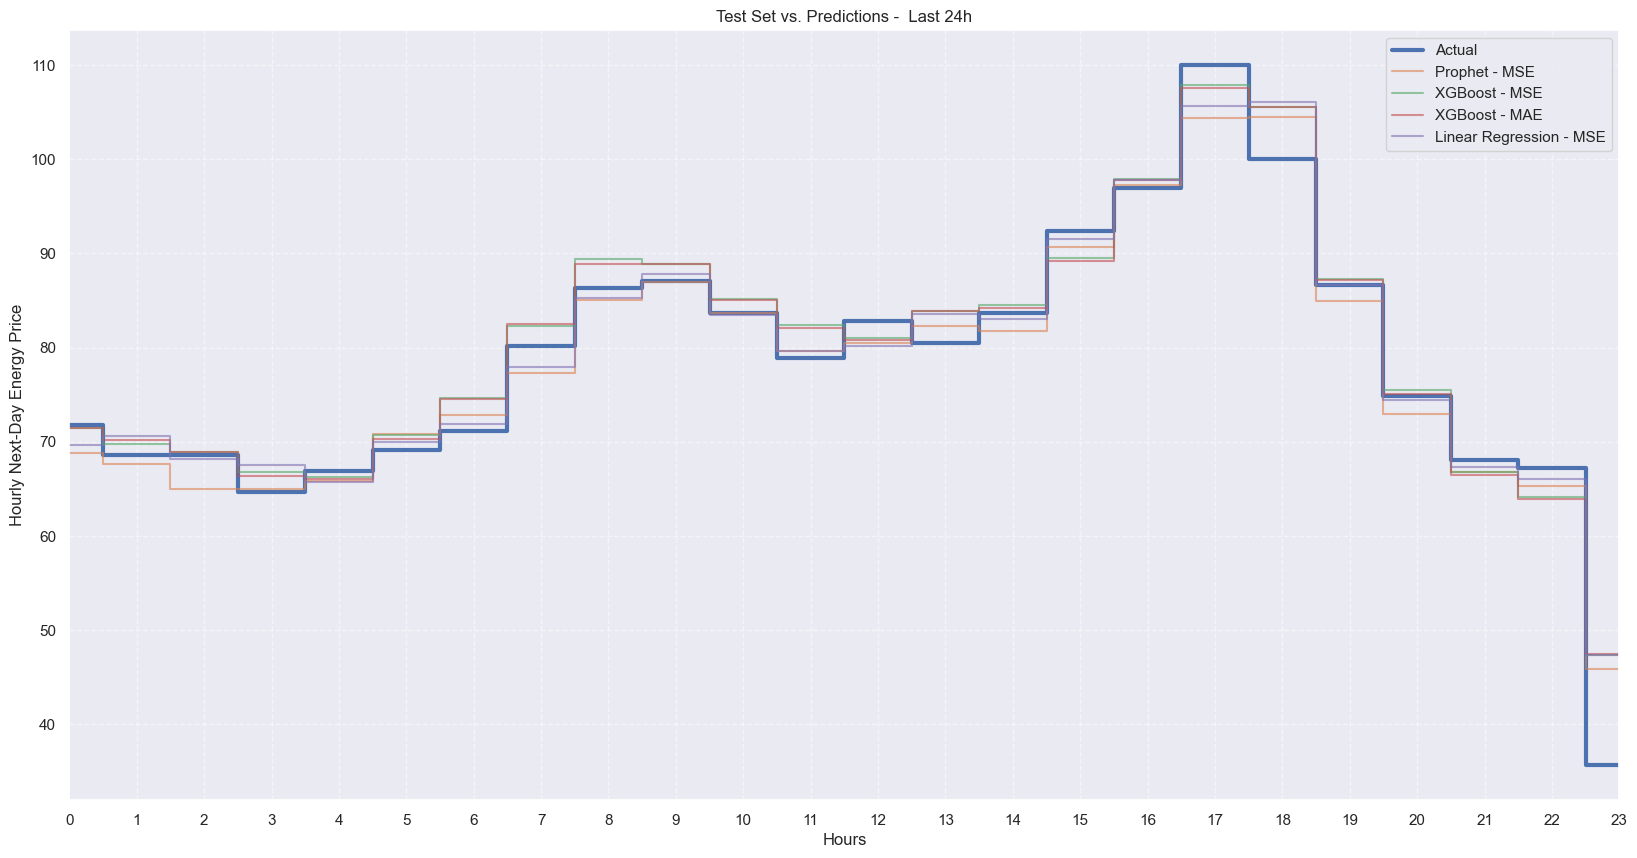

In [13]:
# RERUN WHEN TICKING the NORMALIZED BOX OR SELECTING SPECIFIC FEATURES
predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

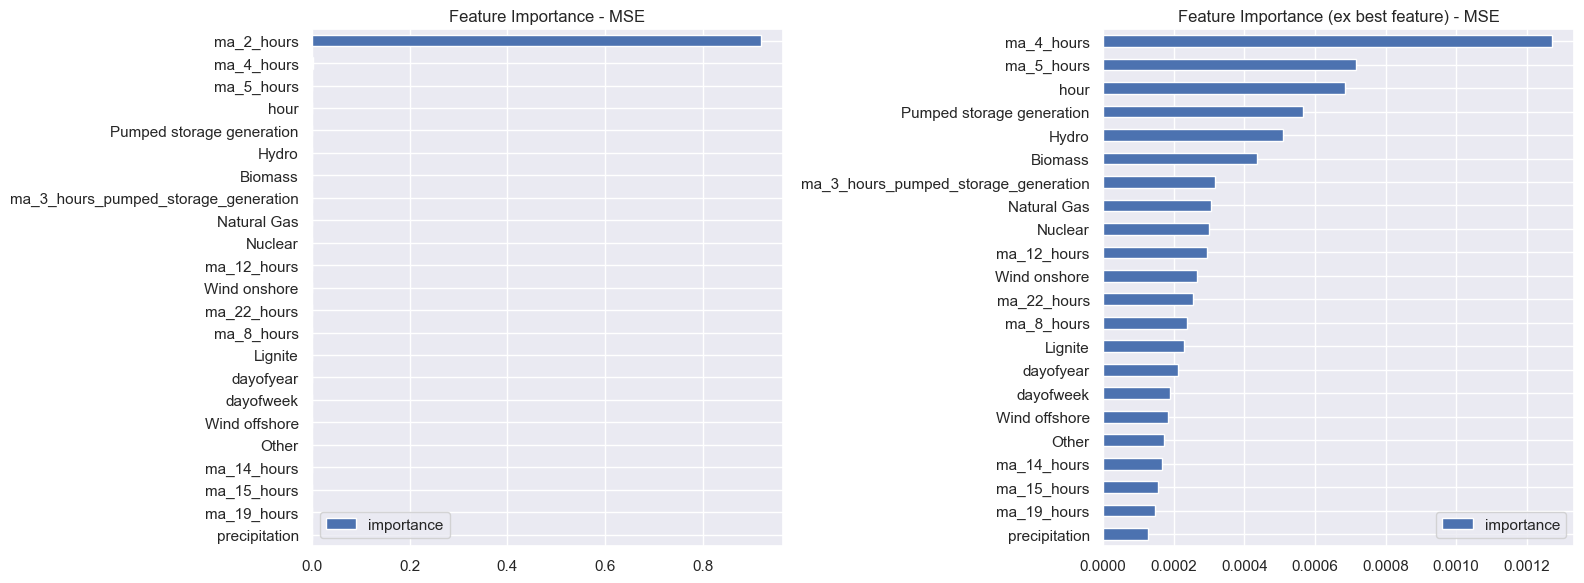

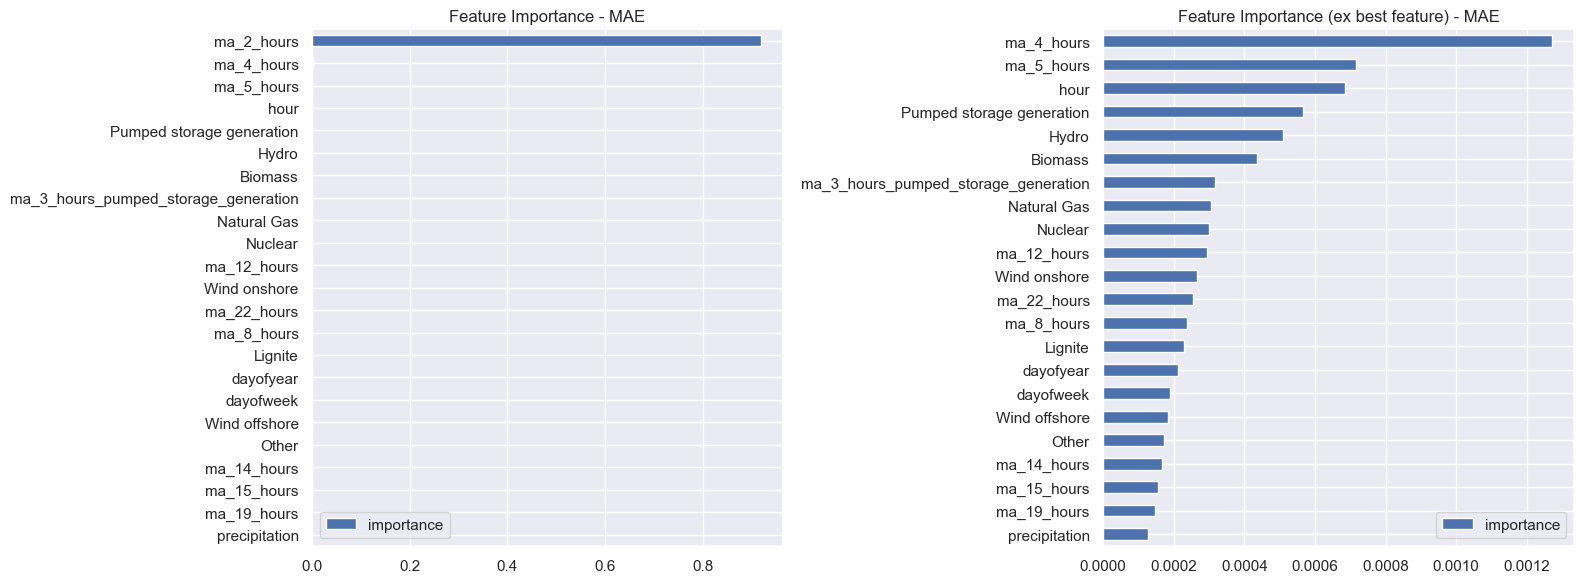

In [14]:
# RERUN WHEN TICKING the NORMALIZED BOX OR SELECTING SPECIFIC FEATURES
feature_importance(xgb_mse, "MSE")
feature_importance(xgb_mae, "MAE")

## Prediction

10:32:53 - cmdstanpy - INFO - Chain [1] start processing
10:33:45 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-01 00:00:00 to 2025-01-02 00:00:00


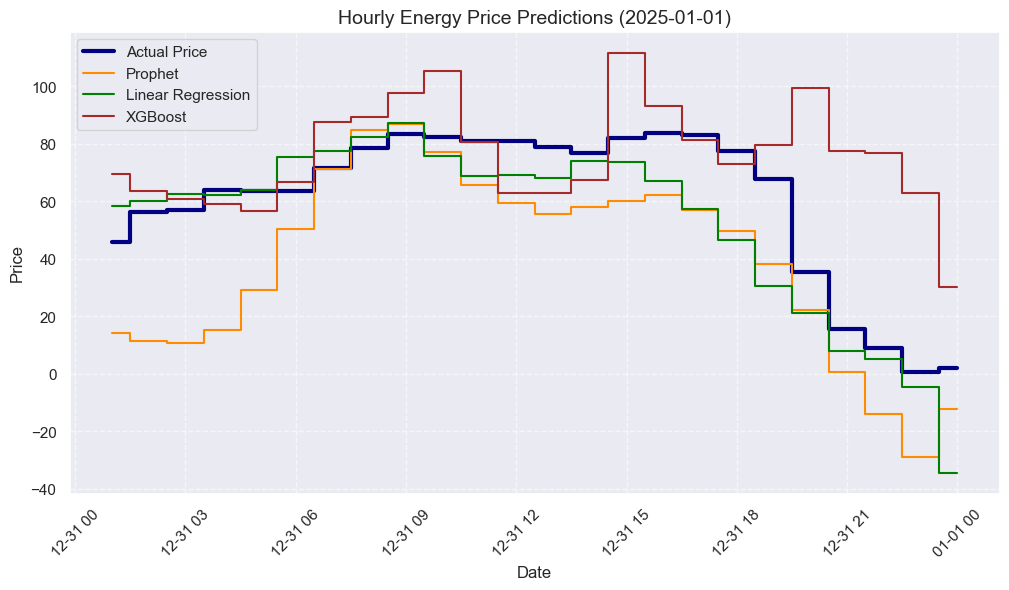

Prophet RMSE: 25.701764566116765
Linear Regression RMSE: 15.637925473891011
XGBoost RMSE: 29.430318961509776



10:33:59 - cmdstanpy - INFO - Chain [1] start processing
10:35:00 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-02 00:00:00 to 2025-01-03 00:00:00


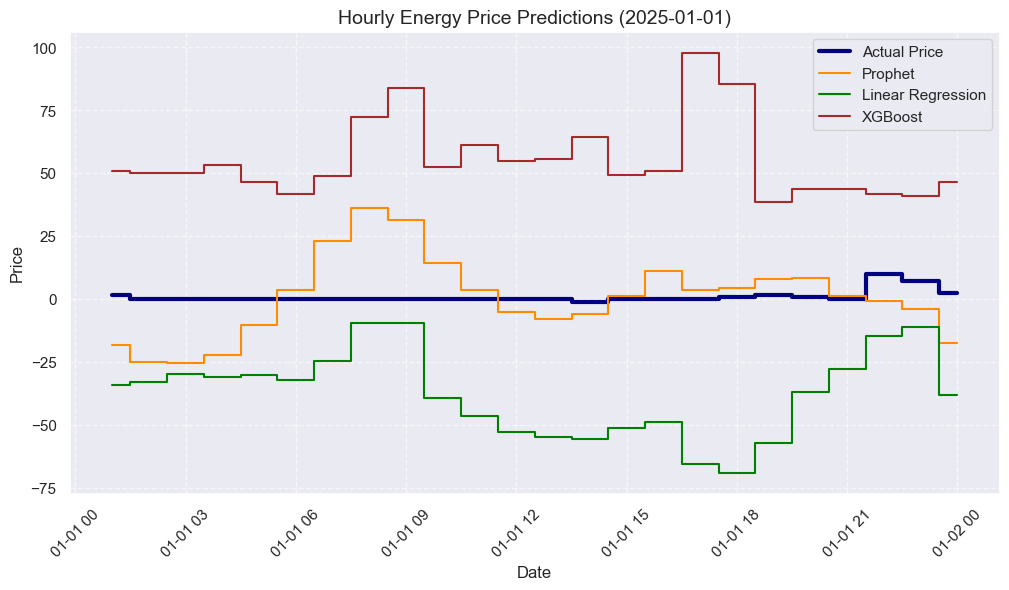

Prophet RMSE: 16.234007765664092
Linear Regression RMSE: 41.79210391490067
XGBoost RMSE: 56.520864984141205



10:35:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:20 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-03 00:00:00 to 2025-01-04 00:00:00


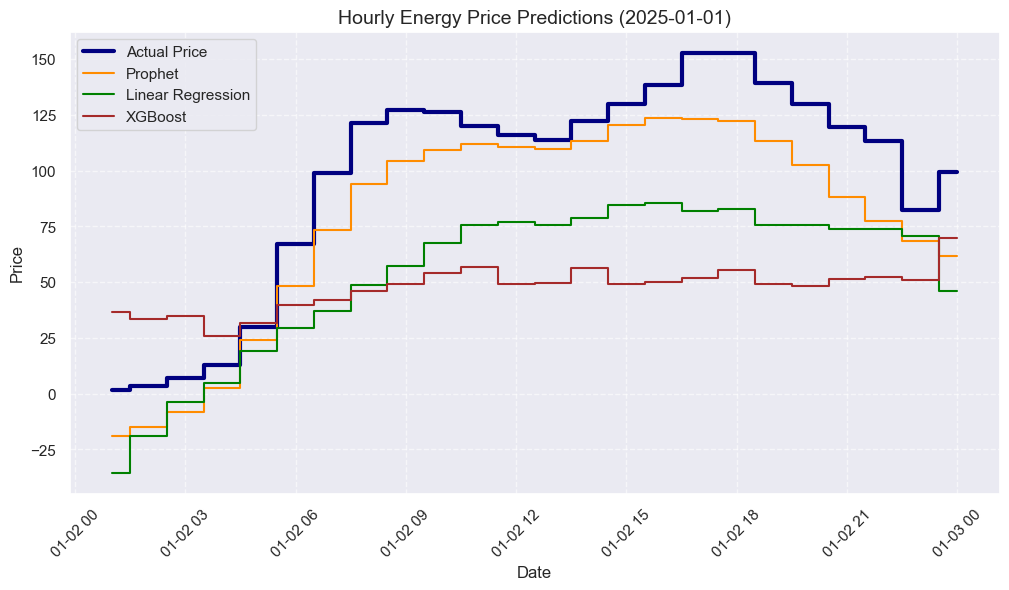

Prophet RMSE: 21.774297250295188
Linear Regression RMSE: 48.49719693229696
XGBoost RMSE: 64.59893756095751



10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-04 00:00:00 to 2025-01-05 00:00:00


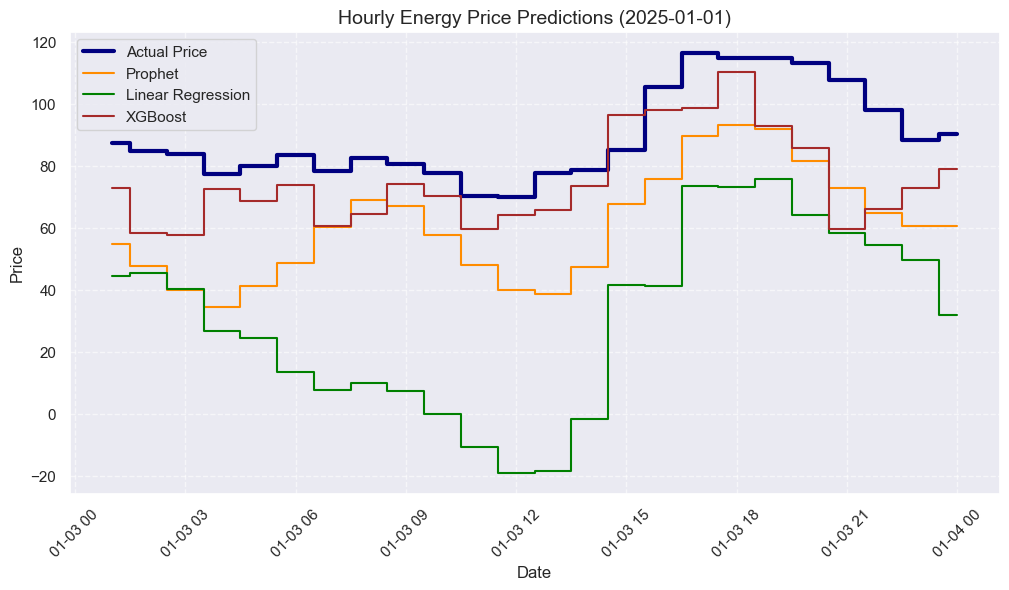

Prophet RMSE: 30.152836575551458
Linear Regression RMSE: 61.467436198326496
XGBoost RMSE: 18.66960912077272



10:37:48 - cmdstanpy - INFO - Chain [1] start processing
10:38:47 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-05 00:00:00 to 2025-01-06 00:00:00


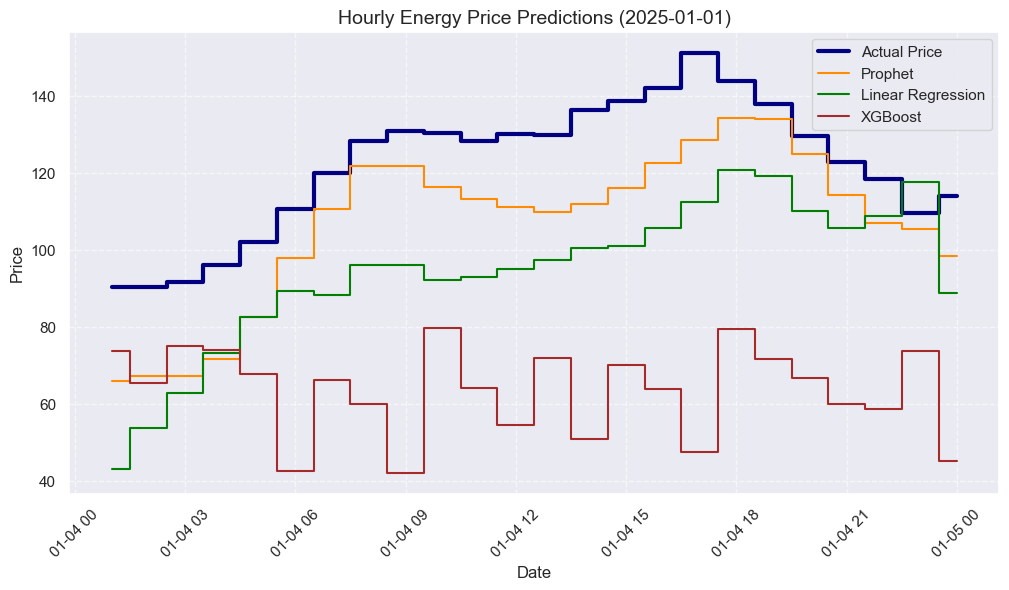

Prophet RMSE: 16.874414920215923
Linear Regression RMSE: 30.199332423434488
XGBoost RMSE: 62.44109016614521



10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:53 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-05 23:00:00 to 2025-01-06 23:00:00


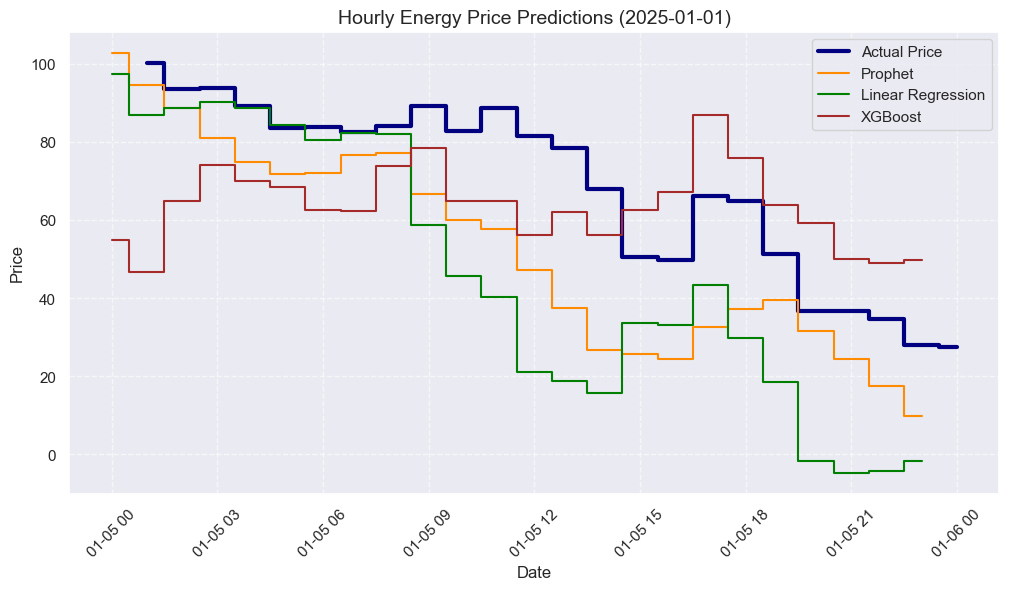

Prophet RMSE: 19.266786455757362
Linear Regression RMSE: 27.963638041662822
XGBoost RMSE: 22.284458983041716



10:40:07 - cmdstanpy - INFO - Chain [1] start processing
10:41:10 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-07 00:00:00 to 2025-01-08 00:00:00


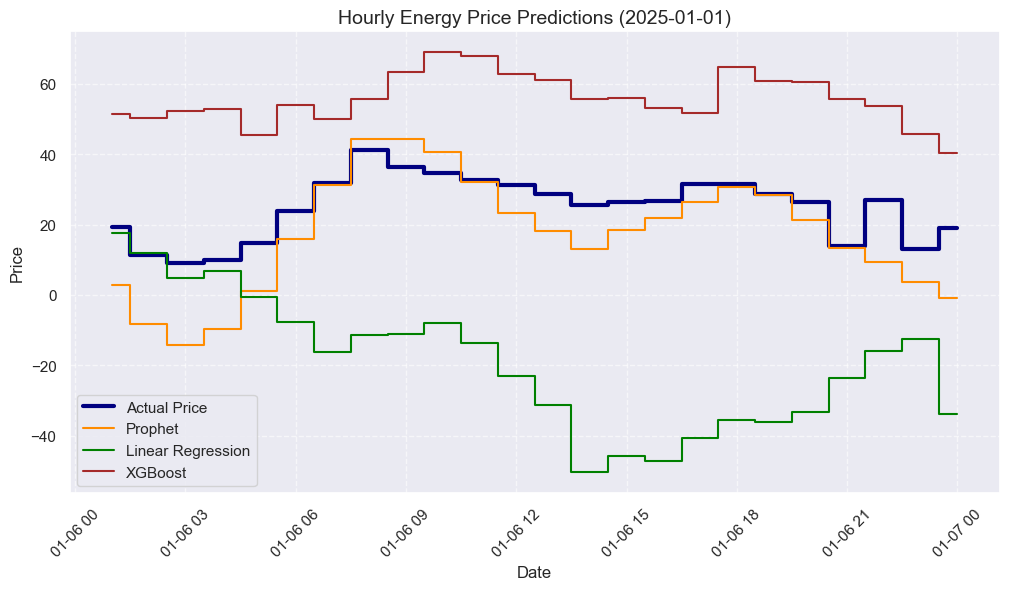

Prophet RMSE: 11.553472733578362
Linear Regression RMSE: 49.9021942812168
XGBoost RMSE: 31.652664307426022



10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:42:28 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-08 00:00:00 to 2025-01-09 00:00:00


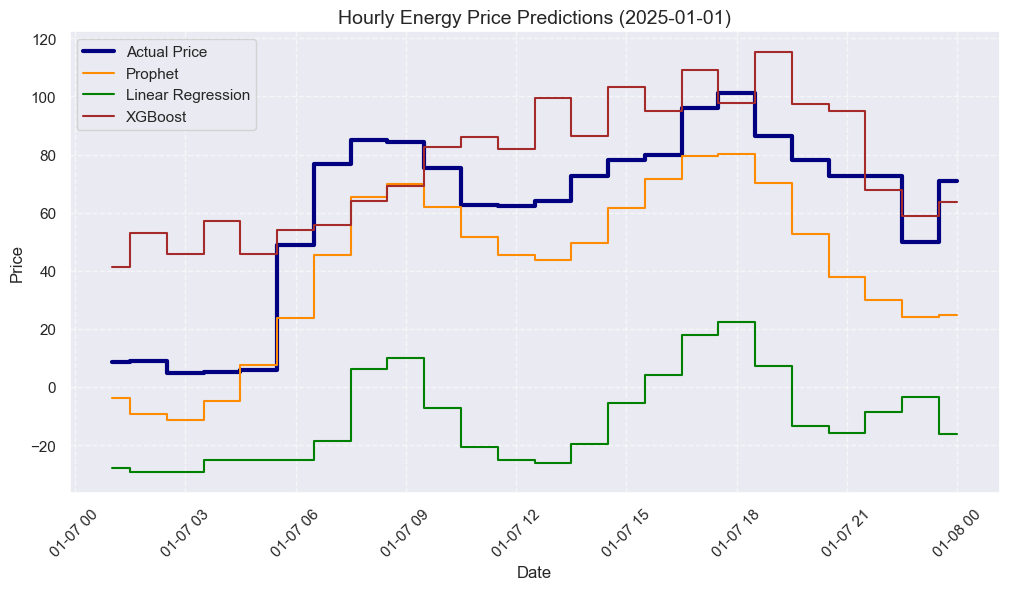

Prophet RMSE: 22.678096159908428
Linear Regression RMSE: 74.86484812598117
XGBoost RMSE: 25.357437292916106



10:42:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-09 00:00:00 to 2025-01-10 00:00:00


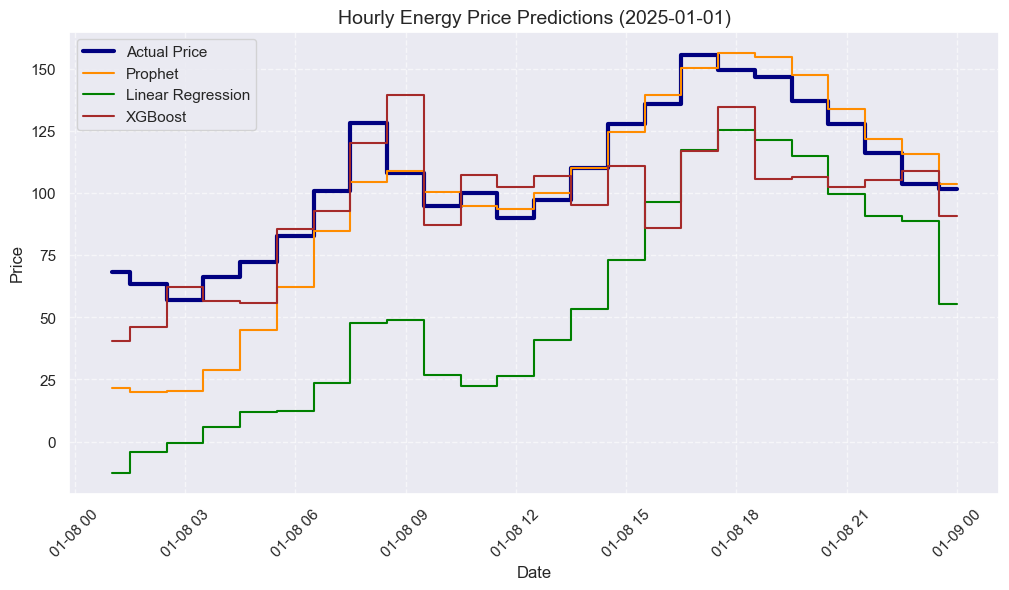

Prophet RMSE: 19.744463027259638
Linear Regression RMSE: 55.927562472097804
XGBoost RMSE: 21.55860779615894



10:43:47 - cmdstanpy - INFO - Chain [1] start processing
10:44:30 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-10 00:00:00 to 2025-01-11 00:00:00


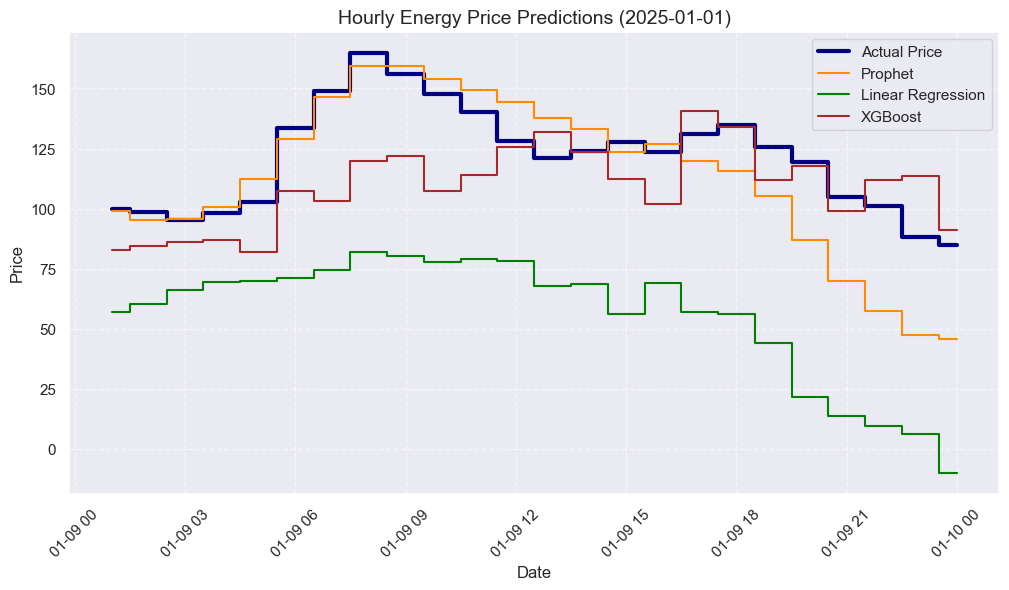

Prophet RMSE: 19.621882769225593
Linear Regression RMSE: 68.67620529205583
XGBoost RMSE: 21.75630703477411



10:44:44 - cmdstanpy - INFO - Chain [1] start processing
10:45:52 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-11 00:00:00 to 2025-01-12 00:00:00


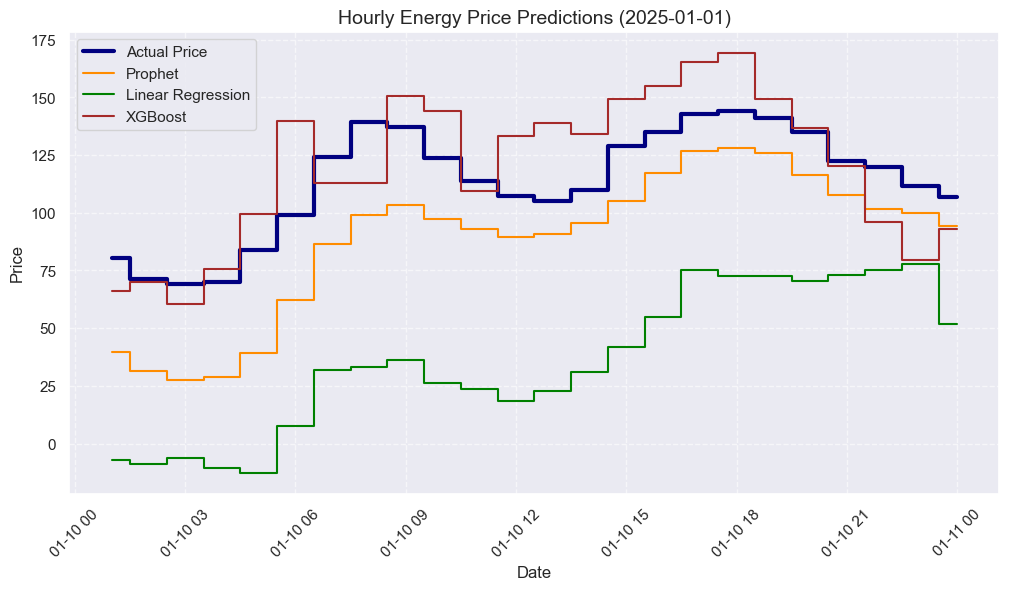

Prophet RMSE: 28.001944712875137
Linear Regression RMSE: 79.94959047260544
XGBoost RMSE: 20.280445760411677



10:46:06 - cmdstanpy - INFO - Chain [1] start processing
10:47:24 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-12 00:00:00 to 2025-01-13 00:00:00


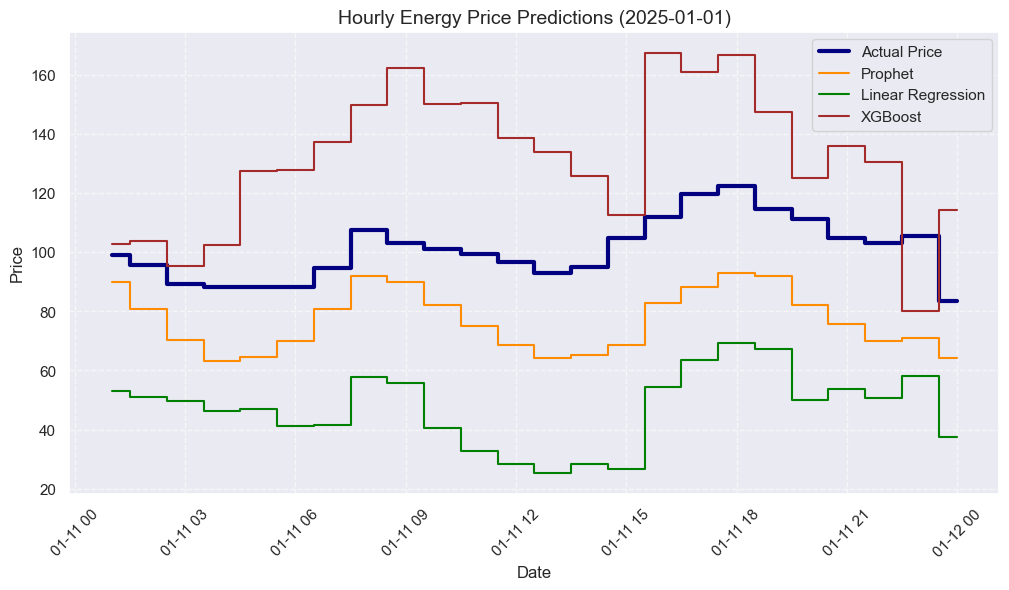

Prophet RMSE: 25.150195814308507
Linear Regression RMSE: 54.71808425747326
XGBoost RMSE: 36.148635074346984



10:47:38 - cmdstanpy - INFO - Chain [1] start processing
10:48:34 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-12 23:00:00 to 2025-01-13 23:00:00


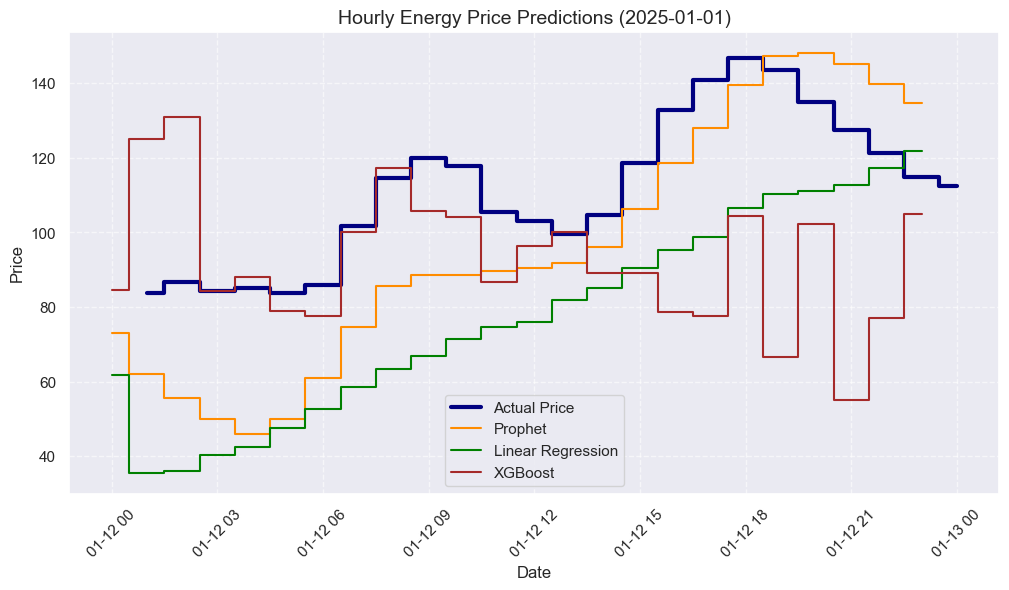

Prophet RMSE: 25.72422468275682
Linear Regression RMSE: 38.04193833656133
XGBoost RMSE: 34.83002115936174



10:48:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:41 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-14 00:00:00 to 2025-01-15 00:00:00


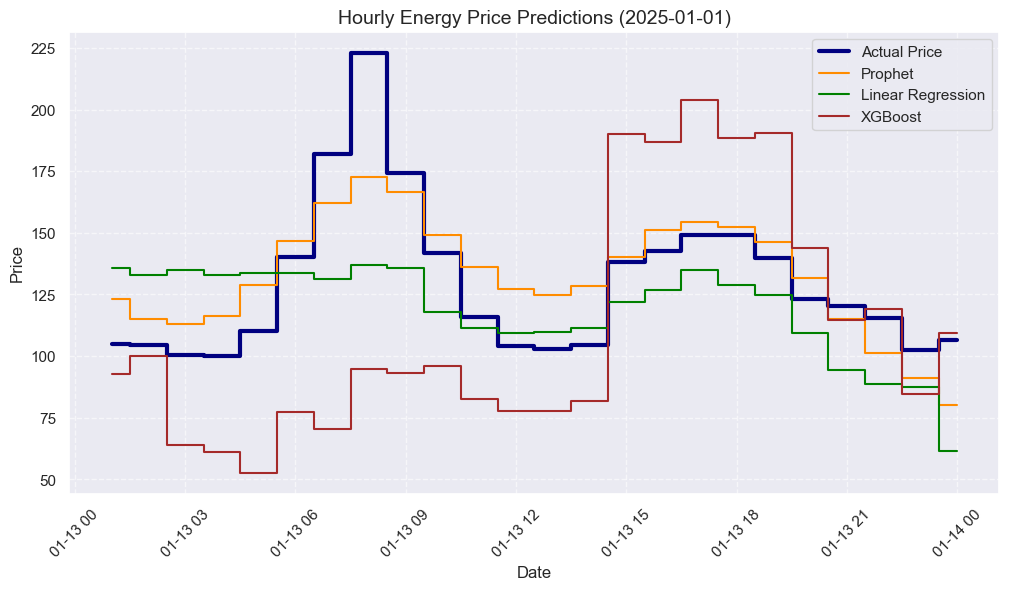

Prophet RMSE: 17.71323879788905
Linear Regression RMSE: 30.2343139971813
XGBoost RMSE: 51.35350929035211



10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:54 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-15 00:00:00 to 2025-01-16 00:00:00


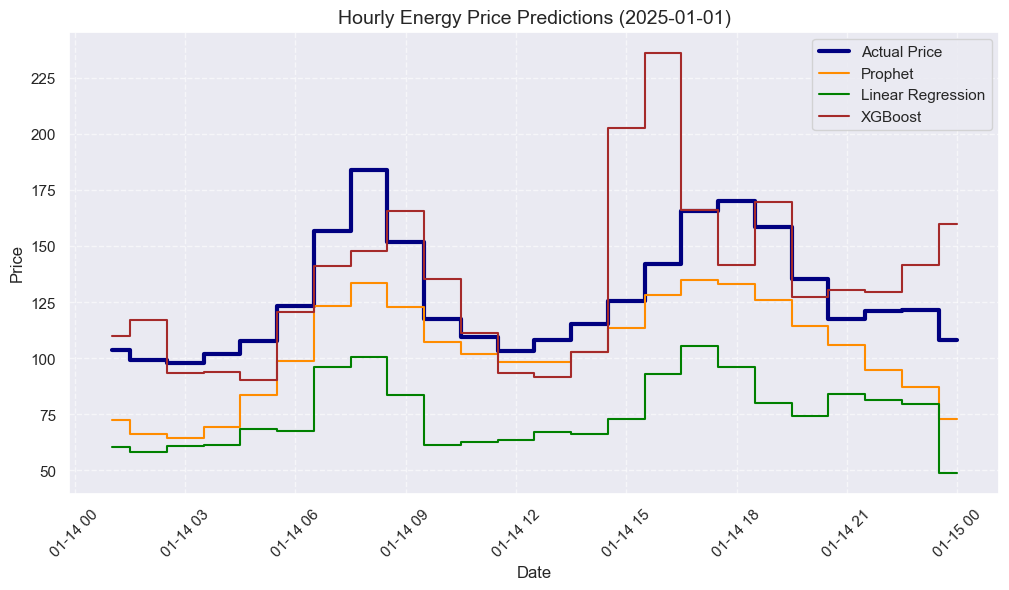

Prophet RMSE: 27.198488360268325
Linear Regression RMSE: 53.877575054571196
XGBoost RMSE: 30.665960489505057



10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:52:19 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-16 00:00:00 to 2025-01-17 00:00:00


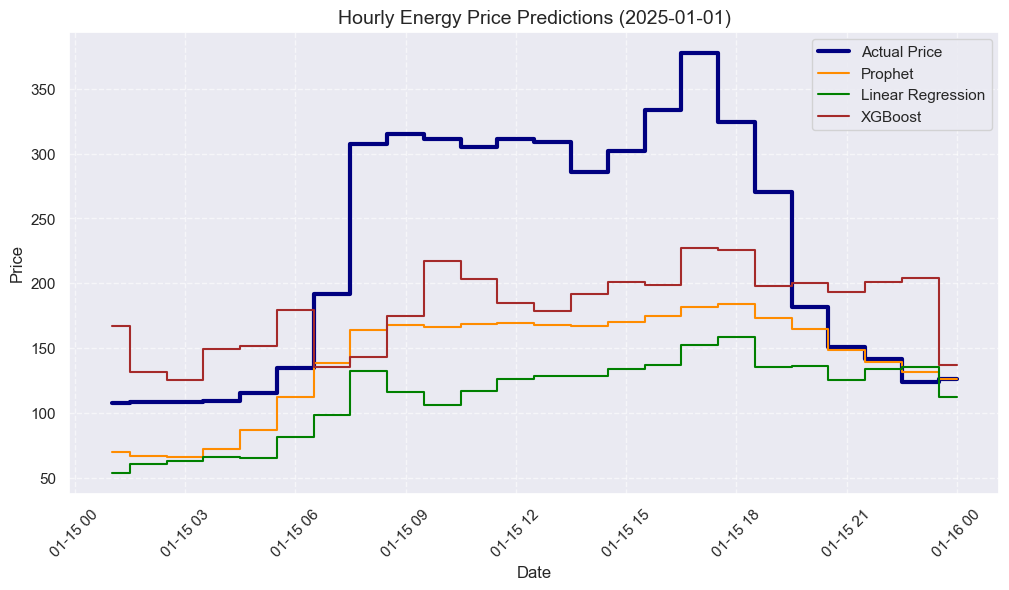

Prophet RMSE: 103.53157134287007
Linear Regression RMSE: 133.68862168373857
XGBoost RMSE: 90.93289573840303



10:52:33 - cmdstanpy - INFO - Chain [1] start processing
10:53:27 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-17 00:00:00 to 2025-01-18 00:00:00


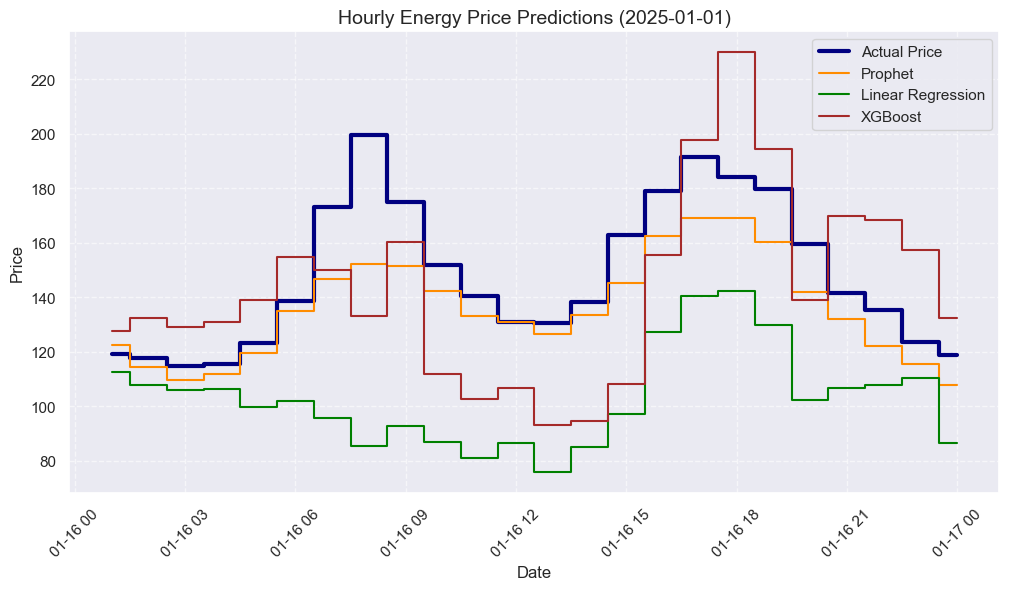

Prophet RMSE: 16.082833659993234
Linear Regression RMSE: 51.58644701761661
XGBoost RMSE: 30.883469146631814



10:53:41 - cmdstanpy - INFO - Chain [1] start processing
10:54:50 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-18 00:00:00 to 2025-01-19 00:00:00


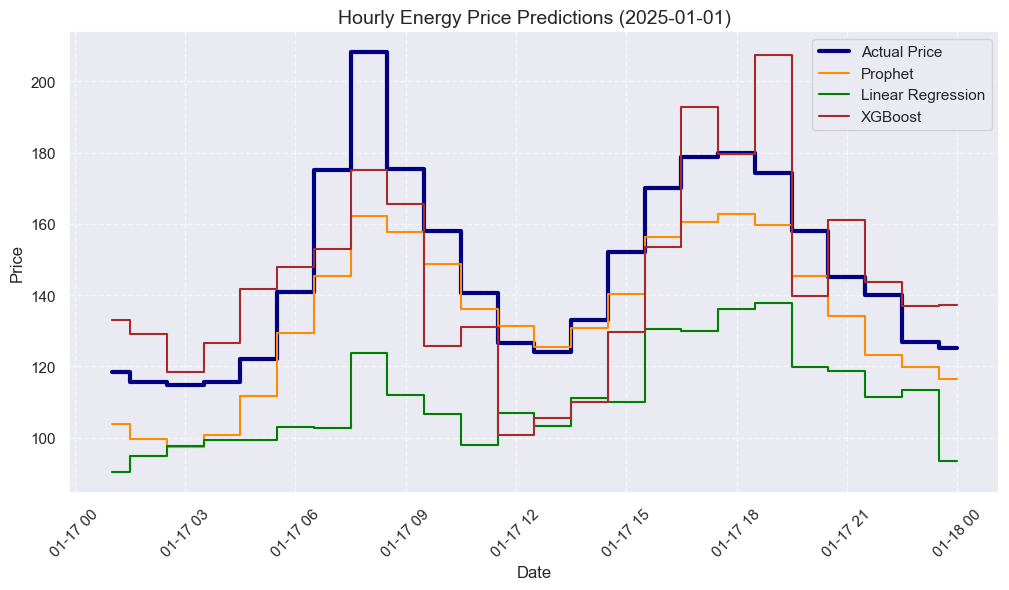

Prophet RMSE: 16.475099096640776
Linear Regression RMSE: 40.28786108601674
XGBoost RMSE: 18.50562064542756



10:55:05 - cmdstanpy - INFO - Chain [1] start processing
10:56:06 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-19 00:00:00 to 2025-01-20 00:00:00


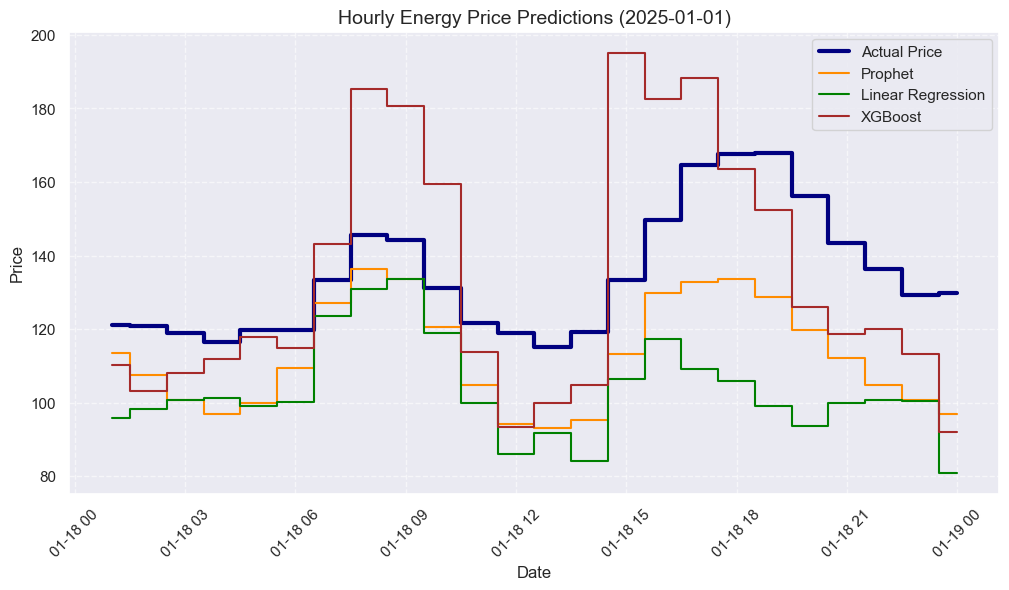

Prophet RMSE: 23.644320284995516
Linear Regression RMSE: 35.409700544252615
XGBoost RMSE: 24.80377414726877



10:56:21 - cmdstanpy - INFO - Chain [1] start processing
10:57:29 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-19 23:00:00 to 2025-01-20 23:00:00


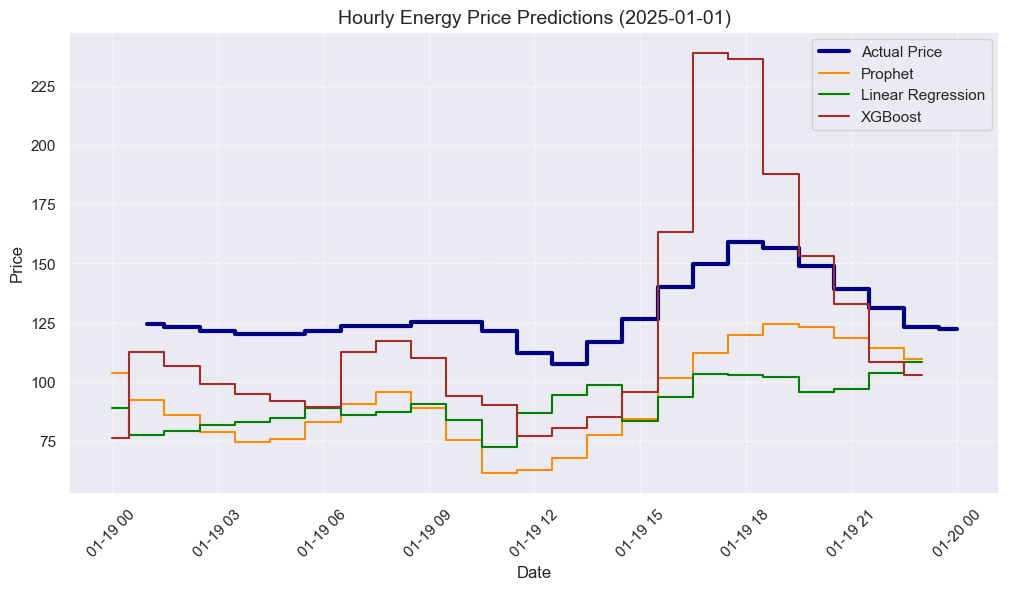

Prophet RMSE: 38.24711794455963
Linear Regression RMSE: 39.52811565348564
XGBoost RMSE: 34.520338143729745



10:57:44 - cmdstanpy - INFO - Chain [1] start processing
10:58:40 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-21 00:00:00 to 2025-01-22 00:00:00


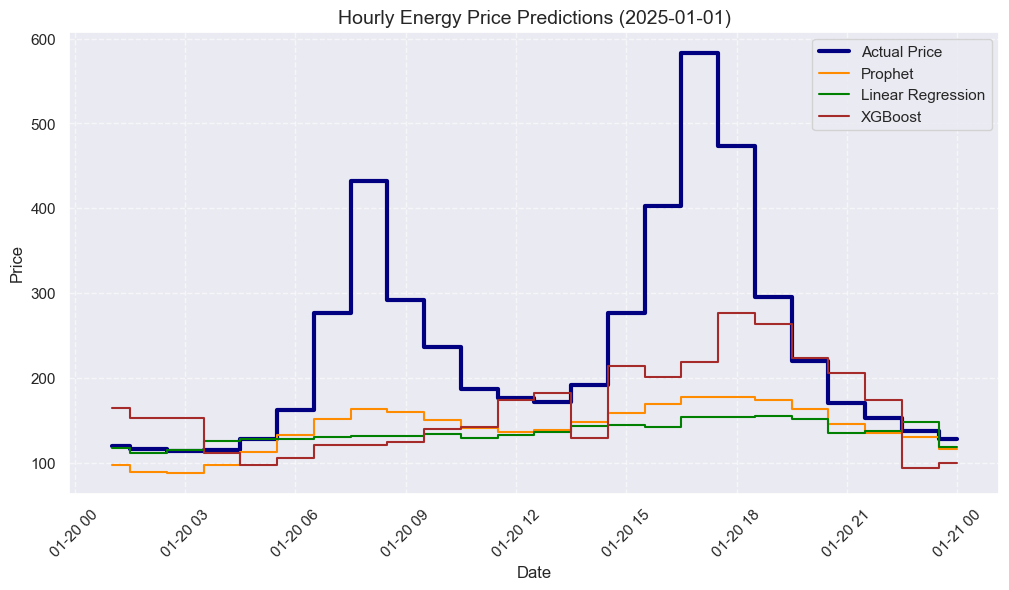

Prophet RMSE: 138.6975998662269
Linear Regression RMSE: 152.08062159929565
XGBoost RMSE: 128.28651330802958



10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:59:59 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-22 00:00:00 to 2025-01-23 00:00:00


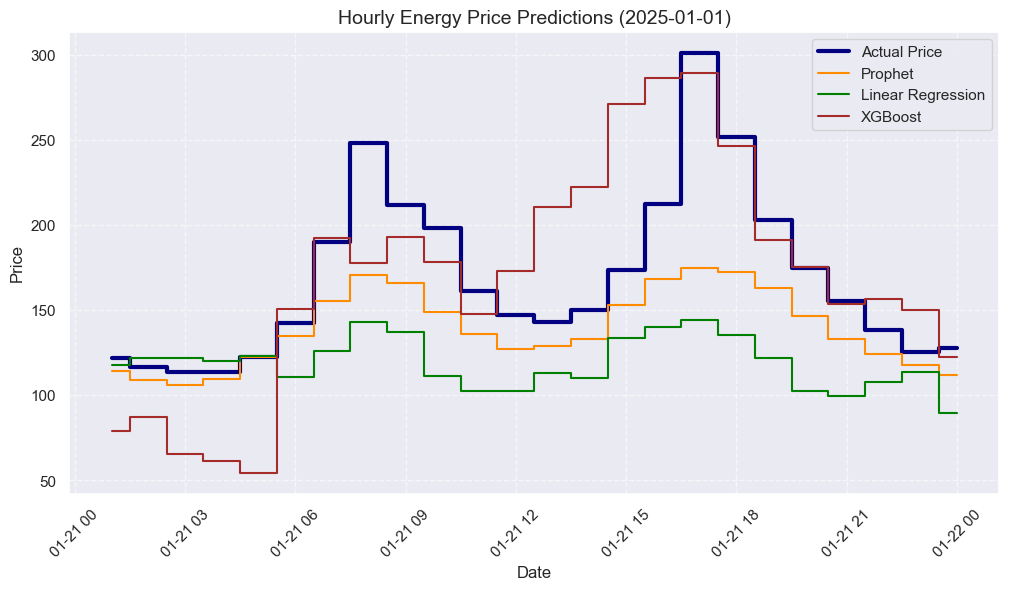

Prophet RMSE: 41.60917746772919
Linear Regression RMSE: 64.47702741326621
XGBoost RMSE: 43.3156946594785



11:00:13 - cmdstanpy - INFO - Chain [1] start processing
11:01:20 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-23 00:00:00 to 2025-01-24 00:00:00


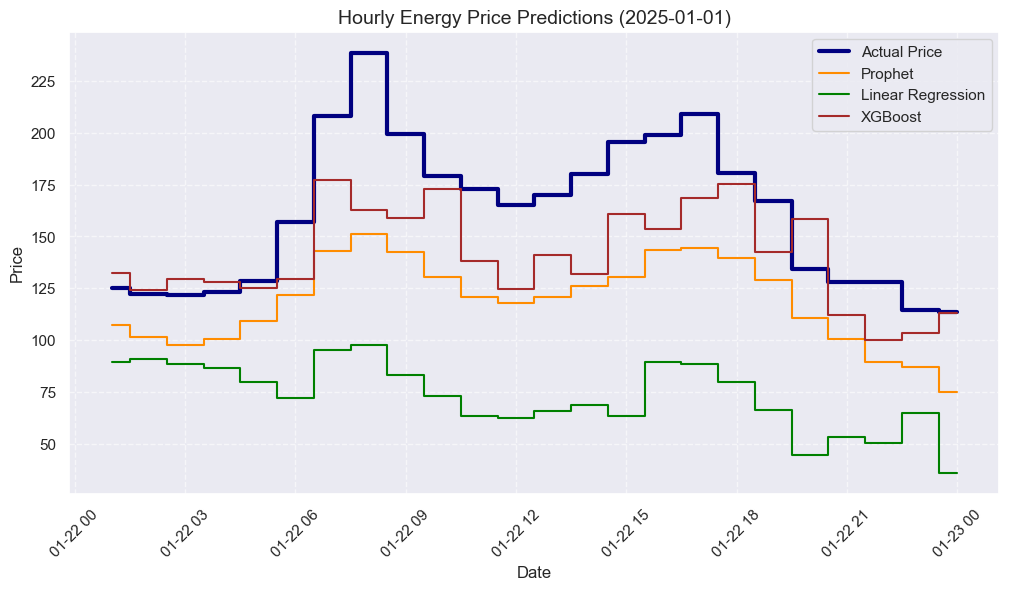

Prophet RMSE: 46.05947073584951
Linear Regression RMSE: 93.58164971797375
XGBoost RMSE: 30.667456197481098



11:01:34 - cmdstanpy - INFO - Chain [1] start processing
11:02:57 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-24 00:00:00 to 2025-01-25 00:00:00


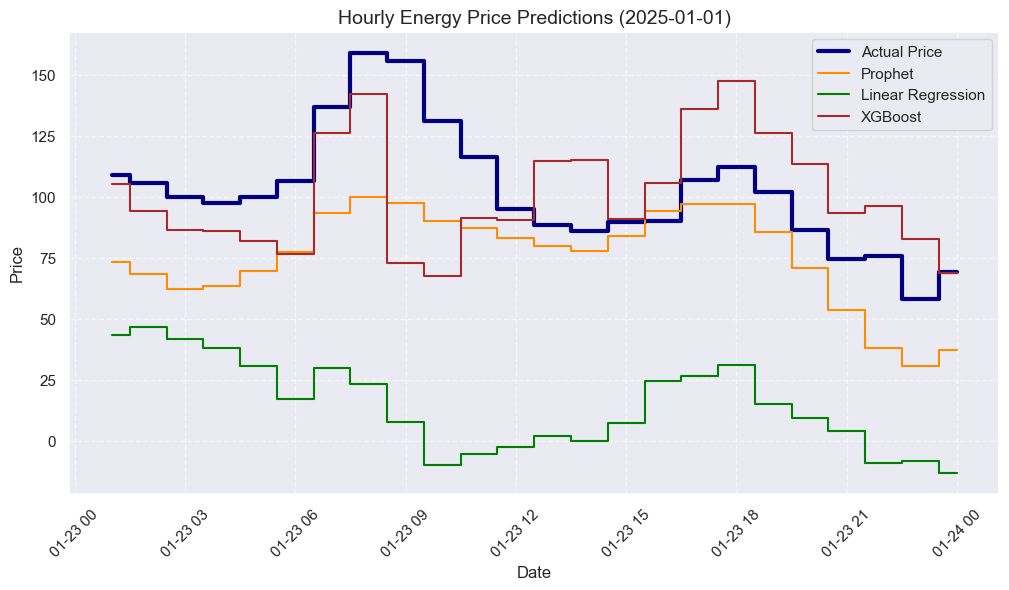

Prophet RMSE: 31.026761489278964
Linear Regression RMSE: 91.05025087478441
XGBoost RMSE: 28.946940484023425



11:03:11 - cmdstanpy - INFO - Chain [1] start processing
11:04:17 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-25 00:00:00 to 2025-01-26 00:00:00


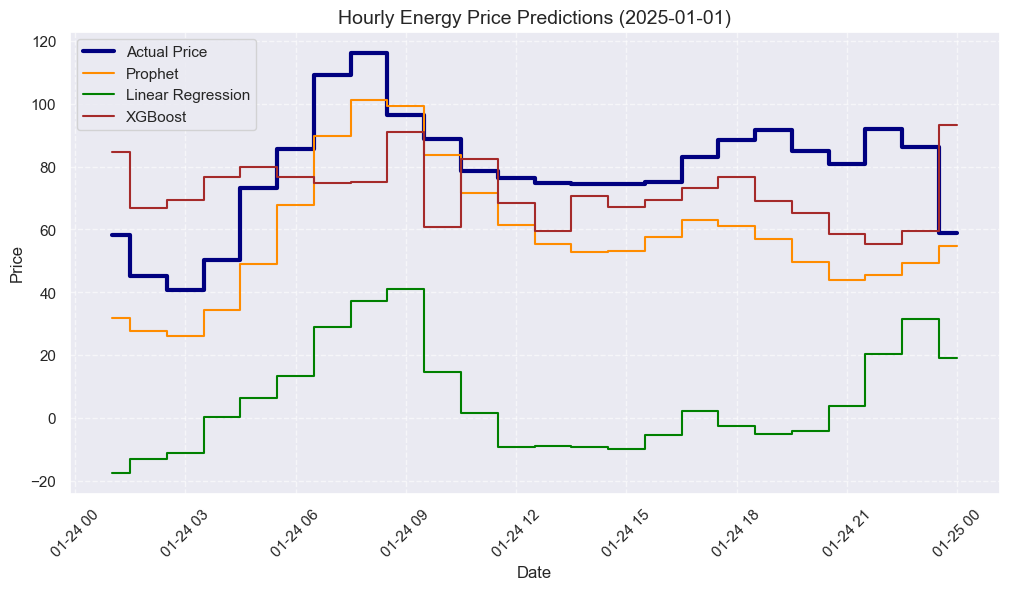

Prophet RMSE: 23.642969220471898
Linear Regression RMSE: 74.6608265962804
XGBoost RMSE: 22.14965998626088



11:04:31 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-26 00:00:00 to 2025-01-27 00:00:00


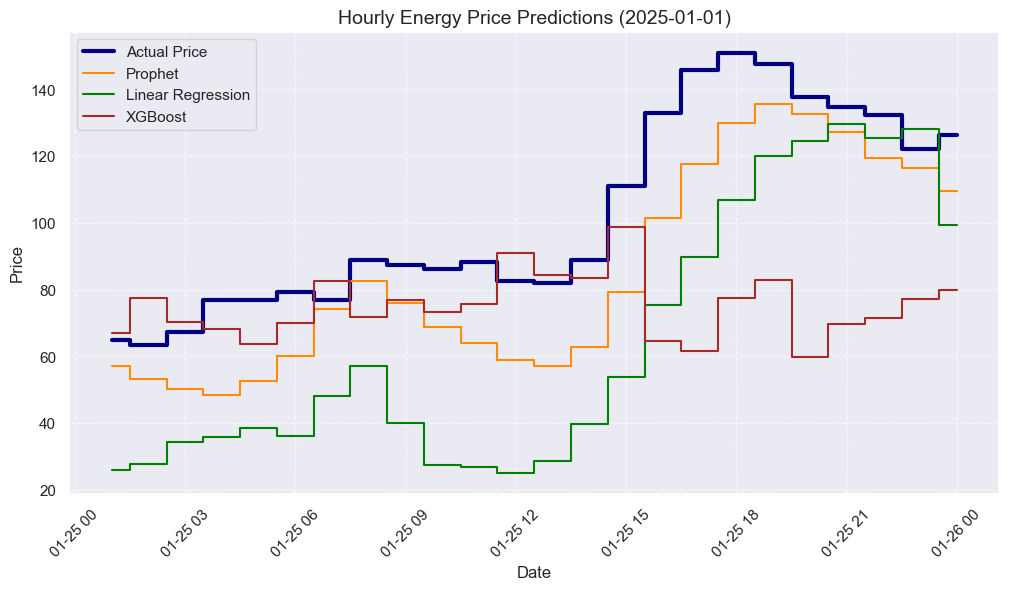

Prophet RMSE: 19.451138618095094
Linear Regression RMSE: 41.93363297817426
XGBoost RMSE: 41.33614646941302



11:05:39 - cmdstanpy - INFO - Chain [1] start processing
11:06:39 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-26 23:00:00 to 2025-01-27 23:00:00


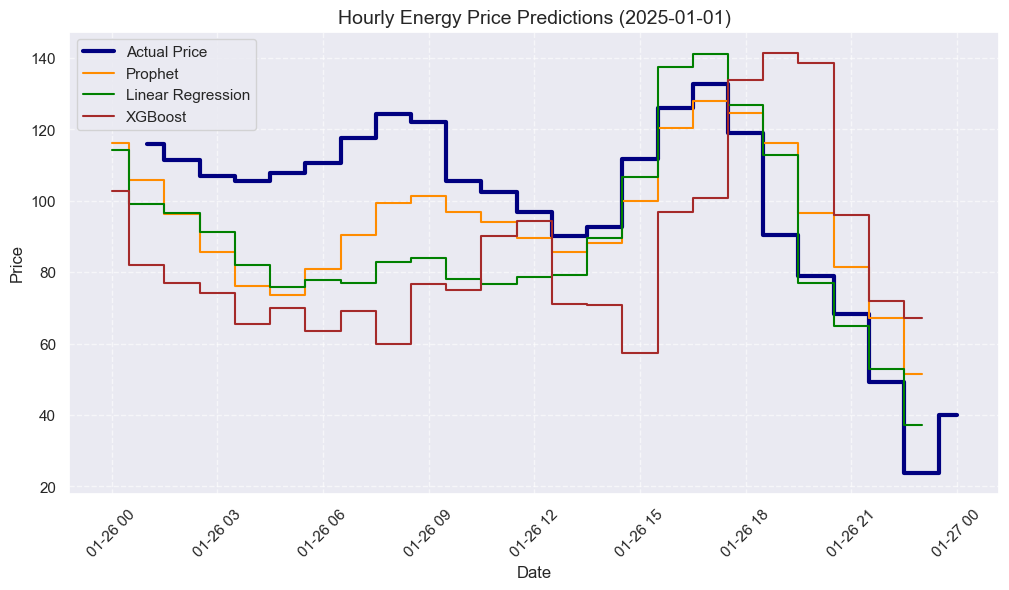

Prophet RMSE: 24.025217270766856
Linear Regression RMSE: 24.568093175830423
XGBoost RMSE: 41.917727884707745



11:06:53 - cmdstanpy - INFO - Chain [1] start processing
11:07:47 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-28 00:00:00 to 2025-01-29 00:00:00


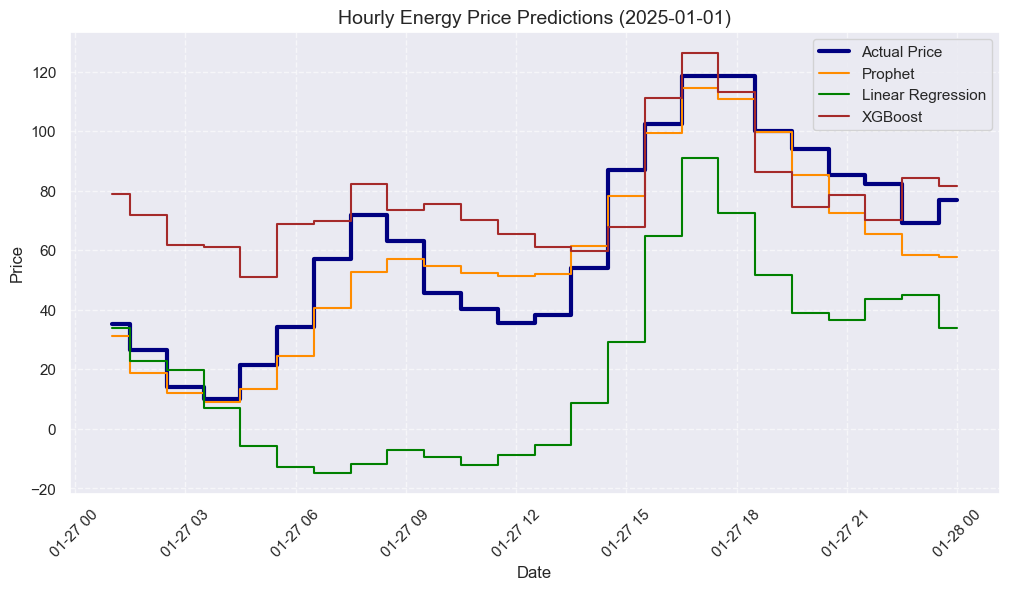

Prophet RMSE: 10.79810578975778
Linear Regression RMSE: 46.145049475197666
XGBoost RMSE: 25.82929404039232



11:08:01 - cmdstanpy - INFO - Chain [1] start processing
11:09:05 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-29 00:00:00 to 2025-01-30 00:00:00


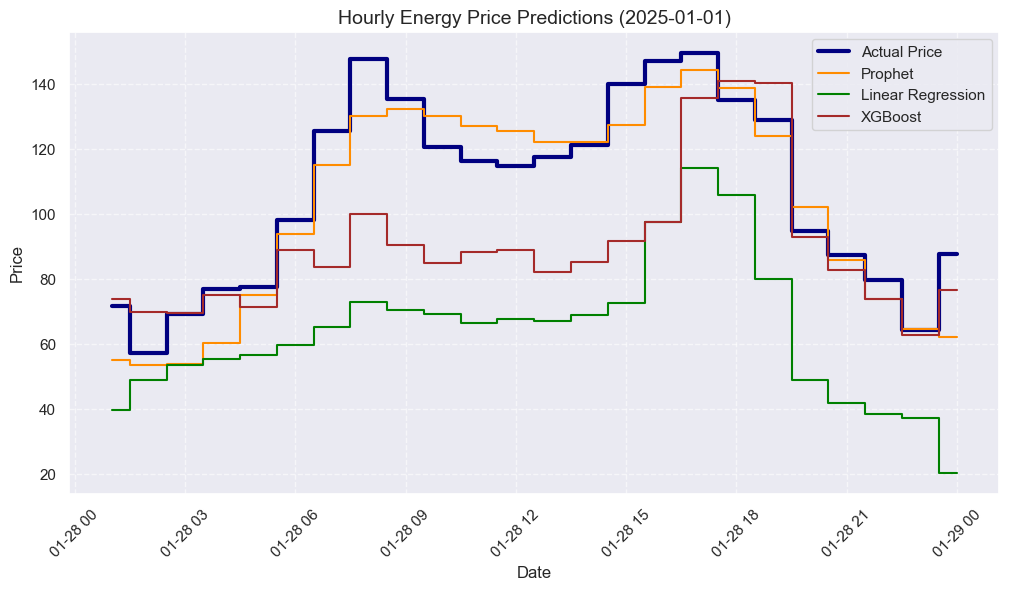

Prophet RMSE: 10.446699986405191
Linear Regression RMSE: 46.70010665261794
XGBoost RMSE: 26.541441040489147



11:09:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:18 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-30 00:00:00 to 2025-01-31 00:00:00


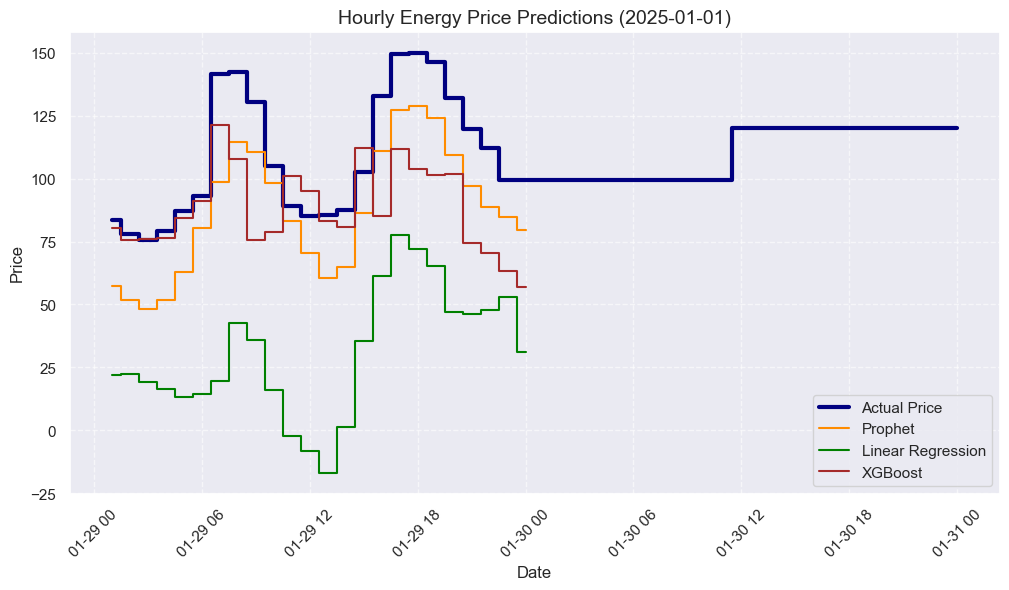

Prophet RMSE: 23.7944942955108
Linear Regression RMSE: 80.74861811728569
XGBoost RMSE: 31.291785521981126

Average RMSEs - Prophet: 29.830756388694063, Linear Regression: 58.2732189286691, XGBoost: 38.2492541798513


In [15]:
# =============================================================================
# Constants and Configurations
# =============================================================================

# Forecasting window settings
HOURS_IN_LAST_MONTH = 24 * 31  # Assuming 31 days in the last month
WINDOW_SIZE = 24             # Forecasting window of 24 hours

# Columns to use from the datasets
COLUMNS = [
    "Price", "Hydro", "Pumped storage generation", "Solar", 
    "Wind offshore", "Wind onshore", "temperature_2m", "precipitation", 
    "wind_speed_100m", "direct_radiation"
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "hour", "dayofyear", "dayofweek",
    "Hydro", "Pumped storage generation",
    "Solar", "Wind offshore", "Wind onshore",
    "temperature_2m", "precipitation", "wind_speed_100m", "direct_radiation"
]

XGB_hyp_params = {
    "base_score": 0.380924762889507,
    # "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

# =============================================================================
# Data Preparation
# =============================================================================

# Split the data into training and benchmarking sets
training_set = merged_df.iloc[:-HOURS_IN_LAST_MONTH][COLUMNS]
benchmarking_set = combined_df.iloc[-HOURS_IN_LAST_MONTH:].copy()

# List to hold RMSE values for each forecasting window
rmses = []

# =============================================================================
# Rolling Forecast Loop
# =============================================================================

for i in range(0, len(benchmarking_set) - WINDOW_SIZE, WINDOW_SIZE):
    # ------------------------- Prophet Model -------------------------
    # Initialize the Prophet model with custom features.
    prophet_model = init_prophet_model(FINAL_FEATURES)
    
    # Extract actual price values for the current 24-hour window.
    y_actual = benchmarking_set.iloc[i:i + WINDOW_SIZE]["Price"]

    # Extend the training data with any benchmarking data available before the current window.
    train_extended = pd.concat((training_set.copy(), benchmarking_set.iloc[:i]))
    train_extended = extend_by_predictions_and_samples(train_extended, train_extended.index[-1])
    train_extended_features = create_features(train_extended.copy())

    # Prepare data for Prophet: 
    # - The forecast dataframe requires a datetime column named "ds".
    prophet_forecast_data = (
        train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]
        .reset_index()
        .rename(columns={"index": "ds"})
    )

    # Prepare the training data for Prophet.
    prophet_training_data = (
        train_extended_features.iloc[:-WINDOW_SIZE][["Price"] + FINAL_FEATURES]
        .rename(columns={"Price": "y"})
        .reset_index()
        .rename(columns={"index": "ds"})
        .dropna()
    )

    # Fit the Prophet model and make predictions.
    prophet_model.fit(prophet_training_data)
    prophet_forecast = prophet_model.predict(prophet_forecast_data)["yhat"]

    # --------------------- Linear Regression Model ---------------------
    X_train_lr = train_extended_features.iloc[:-WINDOW_SIZE][FINAL_FEATURES]
    y_train_lr = train_extended_features.iloc[:-WINDOW_SIZE]["Price"]
    X_forecast_lr = train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]

    lr_model = LinearRegression()
    lr_model.fit(X_train_lr, y_train_lr)
    lr_forecast = lr_model.predict(X_forecast_lr)

    # ------------------------ XGBoost Model ------------------------
    xgb_model = XGBRegressor(**XGB_hyp_params)
    xgb_model.fit(X_train_lr, y_train_lr)
    xgb_forecast = xgb_model.predict(X_forecast_lr)

    # -------------------------- Plotting --------------------------
    # Determine the forecast time window for labeling the plot.
    start_time = train_extended.index[-1]
    end_time = start_time + timedelta(hours=WINDOW_SIZE)
    print(f"Prediction from {start_time} to {end_time}")

    # Adjusting x-ticks to properly align within the given range
    plt.figure(figsize=(12, 6))
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.step(y_actual.index, y_actual,linewidth=3, where="mid", label="Actual Price", color="navy")
    plt.step(prophet_forecast_data["ds"], prophet_forecast, linewidth=1.5, where="mid", label="Prophet", color="darkorange")
    plt.step(X_forecast_lr.index, lr_forecast, linewidth=1.5, where="mid", label="Linear Regression", color="green")
    plt.step(X_forecast_lr.index, xgb_forecast, linewidth=1.5, where="mid", label="XGBoost", color="brown")

    # Formatting the x-axis with properly aligned ticks
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title("Hourly Energy Price Predictions (2025-01-01)", fontsize=14)

    plt.xticks(rotation=45)
    plt.legend(fontsize=11)
    plt.show()

    # --------------------- RMSE Computation ---------------------
    prophet_rmse = mean_squared_error(y_actual, prophet_forecast) ** 0.5
    lr_rmse = mean_squared_error(y_actual, lr_forecast) ** 0.5
    xgb_rmse = mean_squared_error(y_actual, xgb_forecast) ** 0.5

    print(f"Prophet RMSE: {prophet_rmse}")
    print(f"Linear Regression RMSE: {lr_rmse}")
    print(f"XGBoost RMSE: {xgb_rmse}\n")

    rmses.append((prophet_rmse, lr_rmse, xgb_rmse))

# =============================================================================
# Average RMSE Reporting
# =============================================================================

avg_rmse = tuple(sum(x) / len(rmses) for x in zip(*rmses))
print(f"Average RMSEs - Prophet: {avg_rmse[0]}, Linear Regression: {avg_rmse[1]}, XGBoost: {avg_rmse[2]}")
